First, we install the prerequisite packages


In [ ]:
!pip install -q kaggle

Next, we need to import our kaggle id into google colabs

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"dm0469","key":"1e227501e89f832b2233280073205c64"}'}

Next, we need to make a root directory for kaggle:
/root/.kaggle

Then, we move our kaggle id into the root. This allows the kaggle package we installed to view and collect datasets from kaggle.

In [ ]:
!mkdir /root/.kaggle
!cp ./kaggle.json /root/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json
!ls /root/.kaggle/ -al


mkdir: cannot create directory ‘/root/.kaggle’: File exists
total 16
drwxr-xr-x 2 root root 4096 Nov  2 23:40 .
drwx------ 1 root root 4096 Nov  2 23:40 ..
-rw------- 1 root root   62 Nov  2 23:40 kaggle.json


Here we search for the GTZAN dataset on kaggle. this has the genre information we need! we then download the dataset using the ref we found in the dataset list

In [ ]:
!kaggle datasets list -s "GTZAN Dataset - Music Genre Classification"
!kaggle datasets download andradaolteanu/gtzan-dataset-music-genre-classification

ref                                                      title                                        size  lastUpdated          downloadCount  
-------------------------------------------------------  ------------------------------------------  -----  -------------------  -------------  
andradaolteanu/gtzan-dataset-music-genre-classification  GTZAN Dataset - Music Genre Classification    1GB  2020-03-24 14:05:33           2202  
carlthome/gtzan-genre-collection                         GTZAN Genre Collection                        1GB  2019-10-30 07:38:06           1466  
lnicalo/gtzan-musicspeech-collection                     GTZAN music/speech collection               283MB  2017-10-24 12:52:44            927  
maanasdwivedi/gtzan-mix                                  gtzan mix                                     6GB  2020-04-23 02:17:39              2  
alvaromarx/metalhiphopgtzan                              metal-hiphop-gtzan                           46KB  2020-05-19 07:35:27   

Finally, we extract the data into a new directory kaggle_data

In [ ]:
!mkdir kaggle_data
!ls -al

!unzip gtzan-dataset-music-genre-classification.zip -d kaggle_data/

total 1271020
drwxr-xr-x 1 root root       4096 Nov  2 23:42 .
drwxr-xr-x 1 root root       4096 Nov  2 23:15 ..
drwxr-xr-x 1 root root       4096 Oct 28 16:30 .config
-rw-r--r-- 1 root root 1301492495 Nov  2 23:41 gtzan-dataset-music-genre-classification.zip
drwxr-xr-x 2 root root       4096 Nov  2 23:42 kaggle_data
-rw-r--r-- 1 root root         62 Nov  2 23:40 kaggle.json
drwxr-xr-x 1 root root       4096 Oct 28 16:30 sample_data
Archive:  gtzan-dataset-music-genre-classification.zip
  inflating: kaggle_data/Data/features_30_sec.csv  
  inflating: kaggle_data/Data/features_3_sec.csv  
  inflating: kaggle_data/Data/genres_original/blues/blues.00000.wav  
  inflating: kaggle_data/Data/genres_original/blues/blues.00001.wav  
  inflating: kaggle_data/Data/genres_original/blues/blues.00002.wav  
  inflating: kaggle_data/Data/genres_original/blues/blues.00003.wav  
  inflating: kaggle_data/Data/genres_original/blues/blues.00004.wav  
  inflating: kaggle_data/Data/genres_original/blues/blu

Now to get to actually classifying music. First things first, we need to import some packages.

In [ ]:
import os, json, math, librosa
from pathlib import Path

import time, sys
from IPython.display import clear_output
import IPython.display as ipd
import librosa.display

import numpy as np
import statistics
import itertools

from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

import multiprocessing as mp

import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.python.framework.ops import Tensor

from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D

import sklearn.model_selection as sk

from sklearn.model_selection import train_test_split

Next i want to define some variables that we will use for data processing. these include where the data is, the sample rate for the music, the duration, etc.

In [ ]:
MUSIC_FILES_PATH = '/content/kaggle_data/Data/genres_original'
JSON_PATH = "/content/data_10.json"
SAMPLE_RATE = 22050
TRACK_DURATION = 30 # measured in seconds
SAMPLES_PER_TRACK = SAMPLE_RATE * TRACK_DURATION
NUM_SEGMENTS = 6

If you have already processed this file, you can update this field to the process data file path - we wont reprocess the data if this is present.

In [ ]:
DATA_FILE = None
MODEL_FILE = None

Functions used to make the working model:

In [ ]:
def load_data(data_path):
    """Loads training dataset from json file.
        :param data_path (str): Path to json file containing data
        :return X (ndarray): Inputs
        :return y (ndarray): Targets
    """

    with open(data_path, "r") as fp:
        data = json.load(fp)

    # this is here because one of the mfccs we used was not sized properly
    # index_to_delete = [ (index, len(test)) for (index, test) in enumerate(data['mfcc']) if len(test) == 1290][0][0]
    # del data['mfcc'][index_to_delete]
    # del data['labels'][index_to_delete]

    X = np.array(data["mfcc"])
    y = np.array(data["labels"])
    z = np.array(data['mapping'])
    return X, y, z

In [ ]:
def plot_history(history):
    """Plots accuracy/loss for training/validation set as a function of the epochs
        :param history: Training history of model
        :return:
    """

    fig, axs = plt.subplots(2)

    # create accuracy sublpot
    axs[0].plot(history.history["accuracy"], label="train accuracy")
    axs[0].plot(history.history["val_accuracy"], label="test accuracy")
    axs[0].set_ylabel("Accuracy")
    axs[0].legend(loc="lower right")
    axs[0].set_title("Accuracy eval")

    # create error sublpot
    axs[1].plot(history.history["loss"], label="train error")
    axs[1].plot(history.history["val_loss"], label="test error")
    axs[1].set_ylabel("Error")
    axs[1].set_xlabel("Epoch")
    axs[1].legend(loc="upper right")
    axs[1].set_title("Error eval")

    plt.show()

In [ ]:
def prepare_test_datasets(test_size, validation_size):
    """Loads data and splits it into train, validation and test sets.
    :param test_size (float): Value in [0, 1] indicating percentage of data set to allocate to test split
    :param validation_size (float): Value in [0, 1] indicating percentage of train set to allocate to validation split
    :return X_train (ndarray): Input training set
    :return X_validation (ndarray): Input validation set
    :return X_test (ndarray): Input test set
    :return y_train (ndarray): Target training set
    :return y_validation (ndarray): Target validation set
    :return y_test (ndarray): Target test set
    :return z : Mappings for data
    """

    # load data
    X, y, z = load_data(JSON_PATH)

    # create train, validation and test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size)
    X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=validation_size)

    # add an axis to input sets
    X_train = X_train[..., np.newaxis]
    X_validation = X_validation[..., np.newaxis]
    X_test = X_test[..., np.newaxis]

    return X_train, X_validation, X_test, y_train, y_validation, y_test, z

In [ ]:
def build_model(input_shape, previous_model_path=None):
    """Generates CNN model
    :param input_shape (tuple): Shape of input set
    :return model: CNN model
    """

    # if we have a previous model, then return that model instead of building a new one
    if( previous_model_path ):
      return keras.models.load_model(previous_model_path)

    # build network topology
    model = keras.Sequential()   

    # 1st conv layer
    model.add(keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
    model.add(keras.layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same'))
    model.add(keras.layers.BatchNormalization())

    # # 2nd conv layer
    model.add(keras.layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(keras.layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same'))
    model.add(keras.layers.BatchNormalization())

    # 3rd conv layer
    model.add(keras.layers.Conv2D(32, (2, 2), activation='relu'))
    model.add(keras.layers.MaxPooling2D((2, 2), strides=(2, 2), padding='same'))
    model.add(keras.layers.BatchNormalization())

    # flatten output and feed it into dense layer
    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dense(64, activation='relu'))
    model.add(keras.layers.Dropout(0.3))

    # output layer
    model.add(keras.layers.Dense(10, activation='softmax'))

    # compile model
    optimiser = keras.optimizers.Adam(learning_rate=0.0001)
    model.compile(optimizer=optimiser,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

    return model

In [ ]:
def predict_from_test_set(model, X, y):
    """Predict a single sample using the trained model
    :param model: Trained classifier
    :param X: Input data
    :param y (int): Target
    """

    # add a dimension to input data for sample - model.predict() expects a 4d array in this case
    X = X[np.newaxis, ...] # array shape (1, 130, 13, 1)

    # perform prediction
    prediction = model.predict(X)

    # get index with max value
    predicted_index = np.argmax(prediction, axis=1)
    
    # get mappings for target and predicted label
    target = z[y]
    predicted = z[predicted_index]

    print("Target: {}, Predicted label: {}".format(target, predicted))

In [ ]:
def predict( model, X ):
    X = X[np.newaxis, ...]
    prediction = model.predict(X)
    return prediction, np.argmax(prediction, axis=1)

In [ ]:
def process_WAV_file( wav_file_path ):
    n_mfcc=13
    n_fft=2048
    hop_length=512

    signal, sample_rate = librosa.load(wav_file_path, sr=SAMPLE_RATE, duration=30)

    num_samples_per_segment = int(SAMPLES_PER_TRACK / 6)
    num_mfcc_vectors_per_segment = math.ceil(num_samples_per_segment / hop_length)

    # Creates list of mfccs from a single wav file
    list_of_mfccs = []

    for segment in range(6):
      for s in range(6):
        start_sample = num_samples_per_segment * s # s=0 -> 0 seconds
        finish_sample = start_sample + num_samples_per_segment # s=0 -> num_samples_per_segment

        mfcc = librosa.feature.mfcc(signal[start_sample:finish_sample],
                                    sr=sample_rate,
                                    n_fft=n_fft,
                                    n_mfcc=n_mfcc,
                                    hop_length=hop_length)                    

        mfcc = mfcc.T
        data = np.array(mfcc)
        list_of_mfccs.append(data[ ..., np.newaxis])
    return list_of_mfccs
    # return data[ ..., np.newaxis]

In [ ]:
def save_mfcc(dataset_path, json_path, n_mfcc=13, n_fft=2048, hop_length=512, num_segments=5):
    """Extracts MFCCs from music dataset and saves them into a json file along witgh genre labels.
        :param dataset_path (str): Path to dataset
        :param json_path (str): Path to json file used to save MFCCs
        :param num_mfcc (int): Number of coefficients to extract
        :param n_fft (int): Interval we consider to apply FFT. Measured in # of samples
        :param hop_length (int): Sliding window for FFT. Measured in # of samples
        :param: num_segments (int): Number of segments we want to divide sample tracks into
        :return:
        """

    # dictionary to store mapping, labels, and MFCCs
    data = {
        "mapping": [],
        "labels": [],
        "mfcc": []
    }

    num_samples_per_segment = int(SAMPLES_PER_TRACK / num_segments)
    expected_num_mfcc_vectors_per_segment = math.ceil(num_samples_per_segment / hop_length)

    # loop through all genre sub-folder
    for i, (dirpath, dirnames, filenames) in enumerate(os.walk(dataset_path)):

        # ensure we're processing a genre sub-folder level
        if dirpath is not dataset_path:

            # save genre label (i.e., sub-folder name) in the mapping
            semantic_label = dirpath.split("/")[-1]
            data["mapping"].append(semantic_label)
            print("\nProcessing: {}".format(semantic_label))

            # process all audio files in genre sub-dir
            for f in filenames:

		            # load audio file
                file_path = os.path.join(dirpath, f)
                
                # if this file inst jazz00054, process it
                if file_path != '/content/kaggle_data/Data/genres_original/jazz/jazz.00054.wav':

                    # load the song with librosa so we can get mfcc
                    signal, sample_rate = librosa.load(file_path, sr=SAMPLE_RATE, duration=30)

                    # Segmenting wav files
                    for s in range(num_segments):
                      start_sample = num_samples_per_segment * s # s=0 -> 0 seconds
                      finish_sample = start_sample + num_samples_per_segment # s=0 -> num_samples_per_segment

                      mfcc = librosa.feature.mfcc(signal[start_sample:finish_sample],
                                                  sr=sample_rate,
                                                  n_fft=n_fft,
                                                  n_mfcc=n_mfcc,
                                                  hop_length=hop_length)                    
                      mfcc = mfcc.T

                      # store mfcc for segment if it has the expected length
                      if len(mfcc) == expected_num_mfcc_vectors_per_segment:
                        data["mfcc"].append( mfcc.tolist() )
                        data["labels"].append(i-1)
                        print("{}, segment{}".format(file_path, s))


                    # mfcc = librosa.feature.mfcc(signal, sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)  -------- Previous group

                
    # save MFCCs to json file
    print(np.array(data['mfcc']).shape)
    with open(json_path, "w") as fp:
        json.dump(data, fp, indent=4)


Here is how we made the mfcc and saved them. These are what we will feed to our model to predict a genre. 

NOTE: THIS WILL TAKE A WHILE ( around 6 minutes )

In [ ]:
# Runs Data Processing     
save_mfcc(MUSIC_FILES_PATH, JSON_PATH, num_segments=NUM_SEGMENTS)

Streaming output truncated to the last 5000 lines.
/content/kaggle_data/Data/genres_original/reggae/reggae.00037.wav, segment2
/content/kaggle_data/Data/genres_original/reggae/reggae.00037.wav, segment3
/content/kaggle_data/Data/genres_original/reggae/reggae.00037.wav, segment4
/content/kaggle_data/Data/genres_original/reggae/reggae.00037.wav, segment5
/content/kaggle_data/Data/genres_original/reggae/reggae.00007.wav, segment0
/content/kaggle_data/Data/genres_original/reggae/reggae.00007.wav, segment1
/content/kaggle_data/Data/genres_original/reggae/reggae.00007.wav, segment2
/content/kaggle_data/Data/genres_original/reggae/reggae.00007.wav, segment3
/content/kaggle_data/Data/genres_original/reggae/reggae.00007.wav, segment4
/content/kaggle_data/Data/genres_original/reggae/reggae.00007.wav, segment5
/content/kaggle_data/Data/genres_original/reggae/reggae.00075.wav, segment0
/content/kaggle_data/Data/genres_original/reggae/reggae.00075.wav, segment1
/content/kaggle_data/Data/genres_orig

Here is us training the model. We do a 75/25 split for testing/validation.

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 214, 11, 32)       320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 107, 6, 32)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 107, 6, 32)        128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 105, 4, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 53, 2, 64)         0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 53, 2, 64)         256       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 52, 1, 32)         8

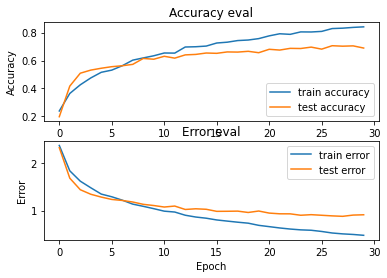

47/47 - 1s - loss: 0.8108 - accuracy: 0.7170

Test accuracy: 0.7169559597969055


In [ ]:
# get train, validation, test splits
X_train, X_validation, X_test, y_train, y_validation, y_test, z = prepare_test_datasets(0.25, 0.2)

# create network
input_shape = (X_train.shape[1], X_train.shape[2], 1)
model = build_model(input_shape, MODEL_FILE )

model.summary()

if( not MODEL_FILE ):

    es_callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

    # train model
    history = model.fit(X_train, y_train, validation_data=(X_validation, y_validation), batch_size=32, epochs=30)

    # plot accuracy/error for training and validation
    plot_history(history)

    # evaluate model on test set
    test_loss, test_acc = model.evaluate(X_test, y_test, verbose=2)
    print('\nTest accuracy:', test_acc)

Here is an example of us geting a prediction from our test set

In [ ]:
# pick a sample to predict from the test set
X_to_predict = X_test[1]
y_to_predict = y_test[1]
print(X_to_predict.shape)
print( X_test.shape )

# predict sample
predict_from_test_set(model, X_to_predict, y_to_predict)

(216, 13, 1)
(1498, 216, 13, 1)
Target: metal, Predicted label: ['metal']


Here we are testing the model on a wav file from the dataset, as well as a random phone recording from the app that has already been built. Since our model was trained on smaller, segmented clips from 30 second wav files, we did the same for our tests. Then, we used the mode from the segmented predictions as the final label.



In [ ]:
test1 = '/content/test.wav'
test2 = '/content/kaggle_data/Data/genres_original/classical/classical.00034.wav'

features = process_WAV_file( test2)

# Creating list of mfcc features
list_of_predicted = []

for mfcc in range(len(features)):
  pred, pred_in = predict(model, features[mfcc])
  list_of_predicted.append(pred_in.tolist())

# Converting to int to get Mode
list_of_predicted = [int(str(x).strip('[]')) for x in list_of_predicted]
mode = statistics.mode(list_of_predicted)

print(list_of_predicted)
print(mode)

# Predicted Classification
print(z[mode])

[8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8]
8
classical


For a final step, we plot a confusion matrix to interpret the results of our model predictions on the final test set.

In [ ]:
def predict_all(model, test_x, test_y):
    """Stores predictions and true labels in separate lists
    to use for confusion matrix
    :param model: Trained classifier
    :param X: test set X values
    :param y: test set y values
    
    """

    list_of_predicted = []
    list_of_true = []

    for i in range(len(test_x)):
      X = test_x[i]
      y = test_y[i]
      # add a dimension to input data for sample - model.predict() expects a 4d array in this case
      X = X[np.newaxis, ...] # array shape (1, 130, 13, 1)

      # perform prediction
      prediction = model.predict(X)

      # get index with max value
      predicted_index = np.argmax(prediction, axis=1)
      
      # get mappings for target and predicted label
      target = z[y]
      predicted = z[predicted_index]
      predicted = np.array2string(predicted).strip('[\'\']')

      list_of_predicted.append(predicted)
      list_of_true.append(target)
    return list_of_predicted, list_of_true

In [ ]:
def plot_confusion_matrix(cm, classes,
                        normalize=False,
                        title='Confusion matrix',
                        cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [ ]:
predicted, true = predict_all(model, X_test, y_test)

In [ ]:
cm = confusion_matrix(y_true=true, y_pred=predicted)

Confusion matrix, without normalization
[[ 95   1  20   5   2  11  14   0   5  10]
 [  0 159   2   0   0   1   0   1   1   3]
 [  1   4 101   2   1   4   3   5   3  10]
 [  3   1   8  90   3   2   1  23  13  12]
 [  3   1   1   9  93   0   5  12  15   3]
 [  2  14  10   1   0 114   0   3   3  13]
 [  1   0   2   2   5   0 128   0   1   4]
 [  0   0   5   3   0   0   0 132   4   5]
 [  0   0   1   7  12   3   0   8  98   6]
 [  5   1  19   9   3   2  19  17  10  64]]


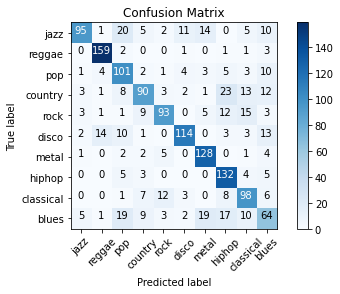

In [ ]:
plot_confusion_matrix(cm=cm, classes=z, title='Confusion Matrix')